# Spam Classification
## Natural Language Processing

#### Author:
Abel Stanley
13517068

# Table of Contents
0. [Constants Definition](#const)
1. [Data Preprocessing](#preprocess)
    1. [Feature Extraction with Keras Tokenizer](#feature_extraction)
    2. [Feature Extraction with TF-IDF](#feature_extraction2)
2. [Neural Network](#nn)
3. [Naive Bayes](#naive_bayes)
4. [Support Vector Machine](#svm)

In [41]:
import tqdm
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
import time
import numpy as np
import pickle

## 0. Constants Definition <a name="const"></a>

In [42]:
BATCH_SIZE = 100 # number of samples per batch
N_EPOCH = 50 # how many N_EPOCH the NN model will be trained
EMBED_SIZE = 100  # for 100 dimension GloVe embedding vectors
SEQ_LEN = 100 # length of sequences (the number of words per sample)

# label encodings:
label_to_int = {"ham": 0, "spam": 1}
int_to_label = {0: "ham", 1: "spam"}

# labels
DATA = 'text'
LABEL = 'type'
COLUMN_LABELS = [LABEL, DATA]

TRAIN = 'train'
VAL = 'validation'
TEST = 'test'
DATASET_LABELS = [TRAIN, VAL, TEST]

TRAIN_LABEL = 'train_label'
VAL_LABEL = 'validation_label'
TEST_LABEL = 'test_label'
DATASET_TYPE_LABELS = [TRAIN_LABEL, VAL_LABEL, TEST_LABEL]

PREFIX_tkn = 'tokenized_'
TRAIN_tkn = 'tokenized_train'
VAL_tkn = 'tokenized_validation'
TEST_tkn = 'tokenized_test'
TOKENIZED_DATA_LABELS = [TRAIN_tkn, VAL_tkn, TEST_tkn]

datasets = {}
# Data paths
PATH_TRAIN = "data/training_data.csv"
PATH_VAL = "data/val_data.csv"
PATH_TEST = "data/testing_data.csv"
MODELS = "models"
LSTM_NAME = 'LSTM'
ANN_NAME = 'ANN'
PATHS = [PATH_TRAIN, PATH_VAL, PATH_TEST]

# helper functions
def apply_to_multiple_datasets(labels, func):
    for label in labels:
        print("applying to", labels)
        func(datasets[label])
        print()
        
def apply_to_multiple_datasets_labels(labels, func):
    for label in labels:
        print("applying to", labels)
        func(datasets[label][LABEL])
        print()

## 1. Data Preprocessing <a name="preprocess"></a>

### 1.1. Load Data

In [43]:
import pandas as pd
def load_csv_data_to_pd(path, labels):
    return pd.read_csv(path, sep=',', header=0, names=labels)

# load the data into pandas df
for path, label in zip(PATHS, DATASET_LABELS):
    datasets[label] = load_csv_data_to_pd(path, COLUMN_LABELS)

### 1.2. Initial look into the data 

#### Train data head

In [44]:
datasets[TRAIN].head()

,type,text
0,ham,"Babe, I'm back ... Come back to me ..."
1,ham,S:)no competition for him.
2,ham,Yup having my lunch buffet now.. U eat already?
3,ham,"Storming msg: Wen u lift d phne, u say HELLO D..."
4,ham,Mark works tomorrow. He gets out at 5. His wor...


#### Validation data head

In [45]:
datasets[VAL].head()

,type,text
0,ham,We can make a baby in yo tho
1,ham,"Aight will do, thanks again for comin out"
2,ham,hope things went well at 'doctors' ;) reminds ...
3,ham,Thanks for this hope you had a good day today
4,ham,No i'm not. I can't give you everything you wa...


#### Testing data head

In [46]:
datasets[TEST].head()

,type,text
0,ham,Anything lor... U decide...
1,ham,So u pay first lar... Then when is da stock co...
2,ham,I got a call from a landline number. . . I am ...
3,ham,Cool. So how come you havent been wined and di...
4,ham,Dunno lei u all decide lor. How abt leona? Oop...


### 1.3. Data distribution peek

In [47]:
datasets[TRAIN][LABEL].value_counts(normalize=True)

ham     0.865837
spam    0.134163
Name: type, dtype: float64

In [48]:
datasets[VAL][LABEL].value_counts(normalize=True)

ham     0.858283
spam    0.141717
Name: type, dtype: float64

In [49]:
datasets[TEST][LABEL].value_counts(normalize=True)

ham     0.870504
spam    0.129496
Name: type, dtype: float64

In [50]:
datasets[TEST][LABEL].describe()

count     556
unique      2
top       ham
freq      484
Name: type, dtype: object

### 1.4. Drop duplicate rows

In [51]:
def drop_duplicate_rows(label):  
    old_row_num = len(datasets[label])
    datasets[label] = datasets[label].drop_duplicates(keep="first", inplace=False) # drop rows in pandas DF with duplicate values
    new_row_num = len(datasets[label])
    print('Duplicate Rows Removal for', label)
    print("Before: ", old_row_num)
    print("After: ", new_row_num)
    print("Diff: ", old_row_num-new_row_num)
    
for label in DATASET_LABELS:
    drop_duplicate_rows(label)

Duplicate Rows Removal for train
Before:  4502
After:  4222
Diff:  280
Duplicate Rows Removal for validation
Before:  501
After:  496
Diff:  5
Duplicate Rows Removal for test
Before:  556
After:  549
Diff:  7


### 1.5. Normalization: Letter case, Punctuation, and Lemmatization

#### a. before normalization

In [52]:
datasets[TRAIN].head(3)

,type,text
0,ham,"Babe, I'm back ... Come back to me ..."
1,ham,S:)no competition for him.
2,ham,Yup having my lunch buffet now.. U eat already?


In [53]:
import spacy
nlp = spacy.load('en_core_web_sm')

def remove_punctuations(df):
    df[DATA] = df[DATA].str.replace('\W', ' ') # remove all punctuations with REGEX
    
def to_lowercase(df):
    df[DATA] = df[DATA].str.lower() # convert all texts into lowercase

def lemmatize(sentence):
    doc = nlp(sentence) 
    return ' '.join(token.lemma_ for token in doc) # reconstruct lemmatized words into full sentences again
    
def lemmatize_df(df):
    df[DATA] = df[DATA].apply(lambda sentence: lemmatize(sentence)) # apply lemmatizaiton to all entries in pandas dataframe column
    
for dataset in datasets.values():
    remove_punctuations(dataset)
    to_lowercase(dataset)
    lemmatize_df(dataset)

#### b. after normalization

In [54]:
datasets[TRAIN].head(3)

,type,text
0,ham,babe i m back come back to -PRON-
1,ham,s no competition for -PRON-
2,ham,yup have -PRON- lunch buffet now u eat already


### 1.6. Text Tokenizations (Feature Extraction)  <a name="feature_extraction"></a>

In [55]:
# Text tokenization: convert sentences into integer encodings
from keras.preprocessing.text import Tokenizer
tokenizer = None

def initTokenizer():
    global tokenizer 
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(datasets[TRAIN][DATA]) # Updates internal vocab based on sentences. Creates a vocabulary index based on word frequency. Lower integer means more frequent word.
    
def tokenize(label):
     return tokenizer.texts_to_sequences(datasets[label][DATA]) # transforms each text into a sequence of integers from word_index dictionary

initTokenizer() # initialize tokenizer and create dictionary from training data

for label in DATASET_LABELS:
    datasets[PREFIX_tkn+label] = tokenize(label)

In [56]:
apply_to_multiple_datasets(TOKENIZED_DATA_LABELS, lambda x: print(x[1:3]))

applying to ['tokenized_train', 'tokenized_validation', 'tokenized_test']
[[16, 32, 1176, 14, 1], [285, 11, 1, 295, 2052, 25, 7, 263, 142]]

applying to ['tokenized_train', 'tokenized_validation', 'tokenized_test']
[[363, 15, 9, 116, 177, 14, 841, 48], [101, 110, 17, 88, 30, 1289, 1119, 1, 2, 81, 65, 3931, 9, 7, 113, 122, 367, 110, 2, 119, 10, 6, 5604]]

applying to ['tokenized_train', 'tokenized_validation', 'tokenized_test']
[[27, 7, 253, 190, 315, 56, 42, 3, 84, 1271, 841], [2, 13, 5, 19, 46, 5, 360, 125, 2, 3, 95, 4, 38, 4, 4191, 4192, 2, 15, 17, 10, 6, 426]]



### 1.7. Convert into numpy array and add paddings to token sequence

In [57]:
from keras.preprocessing.sequence import pad_sequences

# convert tokenized vectors into numpy array (FOR EASIER PROCESSING IN KERAS ML MODEL / SKLEARN ML MODEL)
def to_numpy_arr(vector):
    return np.array(vector)

# add paddings to every sequence at the beginning with 0's
# e.g.: when SEQ_LEN is 4:
# [ [5, 3, 2], [5, 1, 2, 3], [3, 4] ] will be converted into:
# [ [0, 5, 3, 2], [5, 1, 2, 3], [0, 0, 3, 4] ]
def call_pad_sequences(vector):
    return pad_sequences(vector, maxlen=SEQ_LEN)
    
for label in TOKENIZED_DATA_LABELS:
    datasets[label] = to_numpy_arr(datasets[label])

for label in TOKENIZED_DATA_LABELS:
    datasets[label] = call_pad_sequences(datasets[label])
    
for label, label2 in zip(DATASET_TYPE_LABELS, DATASET_LABELS):
    datasets[label] = to_numpy_arr(datasets[label2][LABEL])

## 2. Spam Classification with Neural Networks <a name="nn"></a>

#### a. Training Graph Plotting helper functions

In [58]:
# Training history plotting helper functions:
import matplotlib.pyplot as pyplot

def plot_accuracy(history):
    pyplot.plot(history.history['accuracy'])
    pyplot.plot(history.history['val_accuracy'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['training', 'validation'], loc='lower right')
    pyplot.show()

def plot_loss(history):
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['training', 'validation'], loc='upper right')
    pyplot.show()

#### b. Save and Loading model functions

In [59]:
from keras.models import load_model
import keras_metrics as km
import time

def save_model(name):
    global model
    model.save('{path}/{model_name}_{time}.h5'.format(path=MODELS, model_name=name, time=time.time()))
    
# del model

# load model
def load_nn_model(name):
    return load_model('{path}/{model_name}.h5'.format(path=MODELS, model_name=name),  custom_objects={'binary_precision':km.binary_precision(), 'binary_recall':km.binary_recall()})

#### c. Callbacks for model

In [60]:
# Callbacks:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# to prevent unfruitful epochs from further taking training time:
earlystop_callback = EarlyStopping(patience=5, monitor='val_loss',min_delta=0.0001)

# LR reduction to help recover from stagnation:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# for better visualization:
tensorboard = TensorBoard(log_dir="./logs/spam_classifier_{time.time()}")

callbacks = [earlystop_callback, learning_rate_reduction, tensorboard]

#### d. Prepare data for Neural Networks

In [61]:
import numpy as np

# vectorize data labels (TYPE) into integer encodings
# if 'ham' = 0, if 'spam' = 1 as defined in the dictionary above in constants declaration section
def label_to_vectors(labels):
    res = np.zeros(len(labels))
    for i, label in enumerate(labels):
        res[i] = label_to_int[label.lower()]
    return res

### 2.1. RNN LSTM

#### a. Vectorize data and labels

In [63]:
for label_ in DATASET_TYPE_LABELS:
    datasets[label_+LSTM_NAME] =  label_to_vectors(datasets[label_])

In [64]:
print(datasets[TRAIN_tkn][0])
print(datasets[TRAIN_LABEL+LSTM_NAME])
print(datasets[VAL_tkn][0])
print(datasets[VAL_LABEL+LSTM_NAME][0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 157   2  26  89  38  89   4   1]
[0. 0. 0. ... 0. 1. 0.]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   1  21  69   5 364  10 308 572]
0.0


#### b. Load pre-trained embedding vectors (using GloVe's 100 dimensional vectors)

In [65]:
def get_embedding_vectors(tokenizer, dim=100):
    embedding_index = {}
    # load pre-trained embedding vectors from GloVe to save training time
    with open(f"data/glove.6B.{dim}d.txt", encoding='utf8') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim)) # add 0 paddings according to shape
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words that are not found will be given 0 values
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

#### c. Construct RNN LSTM

In [68]:
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.models import Sequential

def get_model(tokenizer, lstm_units):
    """
    Model structure:
    Embedding vectors => LSTM => 1 Dense layer -> 1 output layer with sigmoid activation func.
    """
    # read the GloVe embedding vector
    embedding_matrix = get_embedding_vectors(tokenizer)
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index)+1,
              EMBED_SIZE,
              weights=[embedding_matrix],
              trainable=False,
              input_length=SEQ_LEN))

    model.add(LSTM(lstm_units, recurrent_dropout=0.2))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="rmsprop", loss="binary_crossentropy",
                  metrics=["accuracy", keras_metrics.precision(), keras_metrics.recall()])
    model.summary()
    return model

In [69]:
# constructs NN model
model = get_model(tokenizer=tokenizer, lstm_units=128)

Reading GloVe: 400000it [00:12, 32563.28it/s]


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          685400    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 257       
Total params: 835,929
Trainable params: 150,529
Non-trainable params: 685,400
__________________________________________

#### d. Train model

In [77]:
from keras.callbacks import ModelCheckpoint, TensorBoard

# model checkpoint for saving best weights
# model_checkpoint = ModelCheckpoint(filepath="/results/spam_classifier", save_best_only=True) # have trouble in making this work!!!

# DATA SHAPES FOR DEBUGGING INPUT:
print("train.shape:", datasets[TRAIN_tkn].shape)
print("validation.shape:", datasets[VAL_tkn].shape)
print("train_labels.shape:", datasets[TRAIN_LABEL].shape)
print("test_labels.shape:", datasets[VAL_LABEL].shape)

# start model training
history = model.fit(datasets[TRAIN_tkn], datasets[TRAIN_LABEL+LSTM_NAME], validation_data=(datasets[VAL_tkn], datasets[VAL_LABEL+LSTM_NAME]),
          batch_size=BATCH_SIZE, epochs=N_EPOCH,
          callbacks=[tensorboard, earlystop_callback],
          verbose=1)

train.shape: (4222, 100)
validation.shape: (496, 100)
train_labels.shape: (4222,)
test_labels.shape: (496,)
Epoch 1/50
43/43 [==============================] - 14s 320ms/step - loss: 0.0211 - accuracy: 0.9927 - precision: 0.9903 - recall: 0.9826 - val_loss: 0.0739 - val_accuracy: 0.9819 - val_precision: 0.9095 - val_recall: 0.9425
Epoch 2/50
43/43 [==============================] - 9s 199ms/step - loss: 0.0212 - accuracy: 0.9953 - precision: 0.9903 - recall: 0.9737 - val_loss: 0.0558 - val_accuracy: 0.9839 - val_precision: 0.9391 - val_recall: 0.9059
Epoch 3/50
43/43 [==============================] - 9s 206ms/step - loss: 0.0097 - accuracy: 0.9976 - precision: 0.9964 - recall: 0.9720 - val_loss: 0.0630 - val_accuracy: 0.9859 - val_precision: 0.9413 - val_recall: 0.9356
Epoch 4/50
43/43 [==============================] - 9s 218ms/step - loss: 0.0070 - accuracy: 0.9983 - precision: 0.9987 - recall: 0.9918 - val_loss: 0.0548 - val_accuracy: 0.9879 - val_precision: 0.9422 - val_recall: 0.

#### f. Save Model

In [78]:
save_model(LSTM_NAME)

#### g. Plot training graph

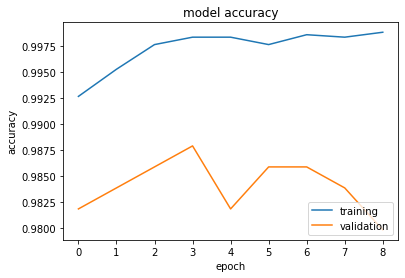

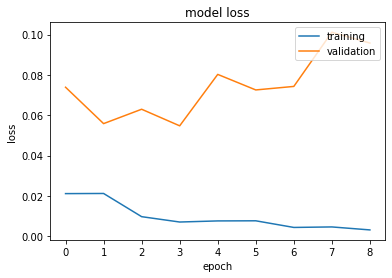

In [79]:
# summarize history for accuracy
plot_accuracy(history)

# summarize history for loss
plot_loss(history)

#### h. Load model if you don't want to train

In [80]:
# model = load_nn_model('LSTM_1601306395.693527')
# model = load_model('models/LSTM_1601306395.693527.h5')

#### i. Evaluate with Keras

In [88]:
# get the loss and metrics
result = model.evaluate(datasets[TEST_tkn], datasets[TEST_LABEL+LSTM_NAME])
# extract the metrics
loss = result[0]
accuracy = result[1]
precision = result[2]
recall = result[3]

# print to screen
print(f"- Accuracy: {accuracy*100:.2f}%")
print(f"- Precision:   {precision*100:.2f}%")
print(f"- Recall:   {recall*100:.2f}%")

18/18 [==============================] - 0s 14ms/step - loss: 0.0921 - accuracy: 0.9854 - precision: 0.9797 - recall: 0.8715
- Accuracy: 98.54%
- Precision:   97.97%
- Recall:   87.15%


#### i. Evaluate with Sklearn 

In [90]:
# Predict
from sklearn.metrics import classification_report

predictions = model.predict_classes(datasets[TEST_tkn])

print(predictions[0][0], type(predictions[0][0]))

0 <class 'numpy.int32'>


In [91]:
# build classification report with sklearn API
print(classification_report(y_true=datasets[TEST_LABEL+LSTM_NAME], y_pred=predictions))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       477
         1.0       0.98      0.90      0.94        72

    accuracy                           0.99       549
   macro avg       0.99      0.95      0.97       549
weighted avg       0.99      0.99      0.99       549



In [86]:
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # add paddings to input text
    sequence = pad_sequences(sequence, maxlen=SEQ_LEN)
    # predict:
    prediction = model.predict(sequence)[0]
    # encode back into terms "spam" or "ham"
    return int_to_label[np.argmax(prediction)]

In [87]:
text = "Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records"
print(get_predictions(text))

text = "Gr8 new service - live sex video chat on your mob - see the sexiest dirtiest girls live on ur phone - 4 details text horny to 89070 to cancel send STOP to 89070"
print(get_predictions(text))

## why?!??!?!

ham
ham


### 2.2. Fully Connected Neural Network (ANN)

#### a. Vectorize data and labels

In [92]:
for label_ in DATASET_TYPE_LABELS:
    datasets[label_+ANN_NAME] =  label_to_vectors(datasets[label_])

In [93]:
datasets[TRAIN_LABEL]

array(['ham', 'ham', 'ham', ..., 'ham', 'spam', 'ham'], dtype=object)

#### b. Construct NN Model

In [94]:
import keras
import keras_metrics

# build layers with Keras API
model = Sequential()
model.add(Dense(8270, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4000, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

c. Train the model

In [95]:
# Train the model
history = model.fit(datasets[TRAIN_tkn], datasets[TRAIN_LABEL+ANN_NAME], validation_data=(datasets[VAL_tkn], datasets[VAL_LABEL+ANN_NAME]),
          batch_size=BATCH_SIZE, epochs=N_EPOCH,
          callbacks=callbacks,
          verbose=1)
model.summary()

Epoch 1/50
43/43 [==============================] - 17s 391ms/step - loss: 60.6991 - accuracy: 0.7520 - precision_4: 0.1824 - recall_4: 0.2675 - val_loss: 4.7654 - val_accuracy: 0.8589 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/50
43/43 [==============================] - 13s 297ms/step - loss: 4.4096 - accuracy: 0.8081 - precision_4: 0.2832 - recall_4: 0.3229 - val_loss: 0.7177 - val_accuracy: 0.8206 - val_precision_4: 0.4059 - val_recall_4: 0.5857
Epoch 3/50
43/43 [==============================] - 13s 296ms/step - loss: 1.5952 - accuracy: 0.8252 - precision_4: 0.3399 - recall_4: 0.3838 - val_loss: 0.6018 - val_accuracy: 0.8851 - val_precision_4: 0.6667 - val_recall_4: 0.3714
Epoch 4/50
43/43 [==============================] - 12s 288ms/step - loss: 1.2278 - accuracy: 0.8389 - precision_4: 0.3818 - recall_4: 0.4114 - val_loss: 0.4939 - val_accuracy: 0.8952 - val_precision_4: 0.6607 - val_recall_4: 0.5286
Epoch 5/50
43/43 [==============================] - 13s 304

#### d.  Save the model

In [96]:
save_model(ANN_NAME)

#### e. Plot training graph

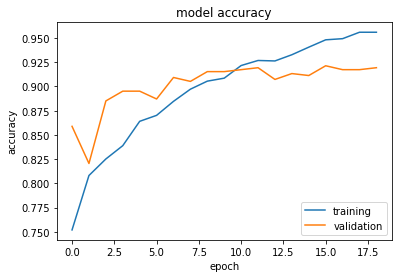

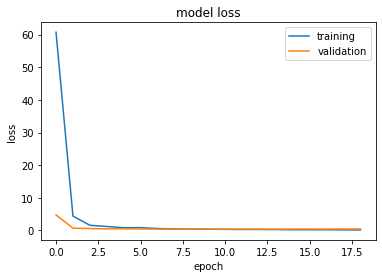

In [97]:
# summarize history for accuracy
plot_accuracy(history)

# summarize history for loss
plot_loss(history)

#### f. Load model if you don't want to train

In [902]:
# model = load_nn_model('ANN_1601306892.6707685')

#### g. Evaluate with Keras 

In [99]:
# get the loss and metrics
result = model.evaluate(datasets[TEST_tkn], datasets[TEST_LABEL+LSTM_NAME])
# extract the metrics
loss = result[0]
accuracy = result[1]
precision = result[2]
recall = result[3]

# print to screen
print(f"- Accuracy: {accuracy*100:.2f}%")
print(f"- Precision:   {precision*100:.2f}%")
print(f"- Recall:   {recall*100:.2f}%")

18/18 [==============================] - 0s 18ms/step - loss: 0.3976 - accuracy: 0.9071 - precision_4: 0.6909 - recall_4: 0.5278
- Accuracy: 90.71%
- Precision:   69.09%
- Recall:   52.78%


#### h. Evaluate with sklearn 

In [100]:
# Predict
from sklearn.metrics import classification_report

predictions = model.predict_classes(datasets[TEST_tkn])

predictions[0:2]

array([[0],
       [0]])

In [101]:
datasets[TEST_LABEL][0]

'ham'

In [102]:
print(classification_report(y_true=datasets[TEST_LABEL+ANN_NAME], y_pred=predictions))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       477
         1.0       0.69      0.53      0.60        72

    accuracy                           0.91       549
   macro avg       0.81      0.75      0.77       549
weighted avg       0.90      0.91      0.90       549



## 2. Spam Classification with Naive Bayes <a name="naive_bayes"></a>

### 2.1. Convert collection of text documents to matrix token counts

In [103]:
# BOW = BAG OF WORDS
# Learn a vocabulary dictionary of all tokens in the raw documents.
from sklearn.feature_extraction.text import CountVectorizer
transform_bow = CountVectorizer().fit(datasets[TRAIN][DATA])

print(len(transform_bow.vocabulary_))

6815


In [105]:
# TEST:
dummy=transform_bow.transform([datasets[TRAIN][DATA][1]])
print(dummy)
print(dummy.shape)

  (0, 1769)	1
  (0, 2630)	1
  (0, 4254)	1
  (0, 4842)	1
(1, 6815)


### 2.2. Transform our datasets

In [107]:
# Transform documents to document-term matrix.
train_bow = transform_bow.transform(datasets[TRAIN][DATA])
test_bow = transform_bow.transform(datasets[TEST][DATA])

In [108]:
print('Sparse matrix shape: ',train_bow.shape)
print('Non-zero occurence count:',train_bow.nnz)

Sparse matrix shape:  (4222, 6815)
Non-zero occurence count: 53442


In [109]:
sparsity =(100.0 * train_bow.nnz/(train_bow.shape[0]*train_bow.shape[1]))
print('sparsity metric :{}'.format(round(sparsity)))

sparsity metric :0


### 2.3. Prepare TF-IDF for term weighting and normalization

In [110]:
# Transform a count matrix to a normalized tf or tf-idf representation
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer().fit(train_bow)
tfidf_dummy = tfidf_transformer.transform(dummy)

print(tfidf_dummy)

  (0, 4842)	0.15827683674147724
  (0, 4254)	0.41214260181675894
  (0, 2630)	0.34752209998718064
  (0, 1769)	0.8272335273302963


In [111]:
# Transform a count matrix to a tf or tf-idf representation
train_tfidf=tfidf_transformer.transform(train_bow)
test_tfidf = tfidf_transformer.transform(test_bow)
print(train_tfidf.shape)

(4222, 6815)


### 2.4. Prepare Naive Bayes Model

In [112]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(train_tfidf, datasets[TRAIN][LABEL])

In [114]:
print('predicted:',spam_detect_model.predict(tfidf_dummy)[0])
print('expected:', datasets[TEST][LABEL][0])

predicted: ham
expected: ham


### 2.5. Construct a pipeline for easier reuse

In [118]:
# automatically extract features with CountVectorizer + TfidfTransformer (or TfidfVectorizer for 1 operation only) and classify with Multinomial NB
# raw input is the pure preprocessed dataset + labels (NO NEED FOR FEATURE EXTRACTION before the pipeline!)

from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('multinb',MultinomialNB()),
])

### 2.6. Train & Evaluate Model (DEFAULT PARAM)

In [120]:
pipeline.fit(datasets[TRAIN][DATA], datasets[TRAIN][LABEL])

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('multinb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [121]:
predictions = pipeline.predict(datasets[TEST][DATA])

In [122]:
from sklearn.metrics import classification_report
print(classification_report(y_true=datasets[TEST][LABEL], y_pred=predictions))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       477
        spam       1.00      0.76      0.87        72

    accuracy                           0.97       549
   macro avg       0.98      0.88      0.92       549
weighted avg       0.97      0.97      0.97       549



### 2.7. Estimate Hyperparameters

In [116]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(pipeline, {
    'bow__ngram_range': [(1, 1), (1, 2)],
    'tfidf__norm': ('l1', 'l2'),
    'tfidf__use_idf': (True, False),
    'tfidf__sublinear_tf': (True, False),
    'tfidf__smooth_idf': (True, False),
    'multinb__fit_prior': [True, False],
    'multinb__alpha': np.linspace(0.1, 1.5, 6) # best: 0.1
})
clf.fit(datasets[VAL][DATA], datasets[VAL][LABEL])

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.9697575757575757
Best Params:  {'bow__ngram_range': (1, 2), 'multinb__alpha': 0.1, 'multinb__fit_prior': True, 'tfidf__norm': 'l2', 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}


### 2.8. Rebuild Pipeline with tuned hyperparameters

In [123]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('bow',CountVectorizer(ngram_range= (1, 2))),
    ('tfidf',TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=True, use_idf=True)),
    ('multinb',MultinomialNB(alpha=0.1, fit_prior=True)),
])

In [124]:
pipeline.fit(datasets[TRAIN][DATA], datasets[TRAIN][LABEL])

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=True,
                                  use_idf=True)),
                ('multinb',
                 MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))],
         verbose=False)

### 2.9. Re-evaluate Model

In [125]:
predictions = pipeline.predict(datasets[TEST][DATA])

In [126]:
from sklearn.metrics import classification_report
print(classification_report(y_true=datasets[TEST][LABEL], y_pred=predictions))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       477
        spam       1.00      0.90      0.95        72

    accuracy                           0.99       549
   macro avg       0.99      0.95      0.97       549
weighted avg       0.99      0.99      0.99       549



In [834]:
# from sklearn.metrics import roc_auc_score
# roc_auc_score(datasets[TEST][LABEL], predictions)

## 3. Spam Classification with SVM <a name="svm"></a>

### 3.1. Encode Data Labels (Feature Extraction) <a name="feature_extraction2"></a>

In [127]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

In [147]:
# use sklearn Label Encoder this time:
Encoder = LabelEncoder() # label normalizer

# Fit label encoder and return encoded labels
Train_Y = Encoder.fit_transform(datasets[TRAIN][LABEL])
Val_Y = Encoder.fit_transform(datasets[VAL][LABEL])
Test_Y = Encoder.fit_transform(datasets[TEST][LABEL])

In [140]:
from sklearn.feature_extraction.text import CountVectorizer
# Learn a vocabulary dictionary of all tokens in the raw documents.
transform_bow = CountVectorizer().fit(datasets[TRAIN][DATA])

# Transform documents to document-term matrix.
train_bow = transform_bow.transform(datasets[TRAIN][DATA])
val_bow = transform_bow.transform(datasets[VAL][DATA])
test_bow = transform_bow.transform(datasets[TEST][DATA])

In [141]:
from sklearn.feature_extraction.text import TfidfTransformer
# Transform a count matrix to a normalized tf or tf-idf representation
tfidf_transformer=TfidfTransformer().fit(train_bow)

# Transform a count matrix to a tf or tf-idf representation
train_tfidf = tfidf_transformer.transform(train_bow)
val_tfidf = tfidf_transformer.transform(val_bow)
test_tfidf = tfidf_transformer.transform(test_bow)

### 3.2. Train SVM (DEFAULT PARAM)

In [148]:
# fit the training dataset on the classifier
SVM = svm.SVC()
SVM.fit(train_tfidf,Train_Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### 3.3. Evaluate SVM (DEFAULT PARAM)

In [149]:
# predict the labels on validation dataset
predictions_SVM = SVM.predict(test_tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  98.72495446265937


In [151]:
print(classification_report(y_true=Test_Y, y_pred=predictions_SVM))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       477
           1       1.00      0.90      0.95        72

    accuracy                           0.99       549
   macro avg       0.99      0.95      0.97       549
weighted avg       0.99      0.99      0.99       549



### 3.4. Search for best hyperparameters with Grid Search

In [152]:
param_grid = {'C': [0.1,1, 10, 100], 'break_ties': (True,False),'gamma': [1,0.1,0.01,0.001, 'scale'],'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(svm.SVC(), param_grid)
clf.fit(val_tfidf, Val_Y)

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.9596565656565657
Best Params:  {'C': 10, 'break_ties': True, 'gamma': 1, 'kernel': 'linear'}


### 3.5. Build and Train optimized SVM

In [153]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=10, break_ties=True, kernel='linear', degree=3, gamma=1)
SVM.fit(train_tfidf,Train_Y)

SVC(C=10, break_ties=True, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### 3.6. Re-evaluate SVM

In [157]:
# predict the labels on validation dataset
predictions_SVM = SVM.predict(test_tfidf)
# Calculate SVM accuracy
print("SVM's accuracy score : ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM's accuracy score :  98.54280510018215


In [158]:
print(classification_report(y_true= Test_Y, y_pred=predictions_SVM))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       477
           1       0.97      0.92      0.94        72

    accuracy                           0.99       549
   macro avg       0.98      0.96      0.97       549
weighted avg       0.99      0.99      0.99       549

